# Assignment 7

In this assignment, we'll use our two variational inference algorithms, and compare their speed and output to MCMC.

## Instructions

Please complete this Jupyter notebook and **don't** convert it to a `.py` file. Upload this notebook, along with any `.stan` files and any data sets as a `zip` file to Gradescope. Your work will be manually graded by our TA. 


In [69]:
import pandas as pd
import numpy as np
import os
from cmdstanpy import CmdStanModel
import matplotlib.pyplot as plt

### Problem 1: A Derivation

In lecture it was mentioned that the KL-divergence is an intractable quantity. However, the **Evidence Lower Bound (ELBO)**  is usually not. Your goal is to show that this.

Show

\begin{align*}
\text{KL}(g || p) 
&= - \mathbb{E}_{g}\left[ \log\frac{  L(y  \mid \theta) \pi(\theta \mid y)}{g(\theta \mid \phi)} \right] +  \text{constant}  
\end{align*}

Or in other words, show that  the ELBO--the expectation without the negative sign on the right hand side--doesn't involve the unknown normalizing constant $p(y)$.

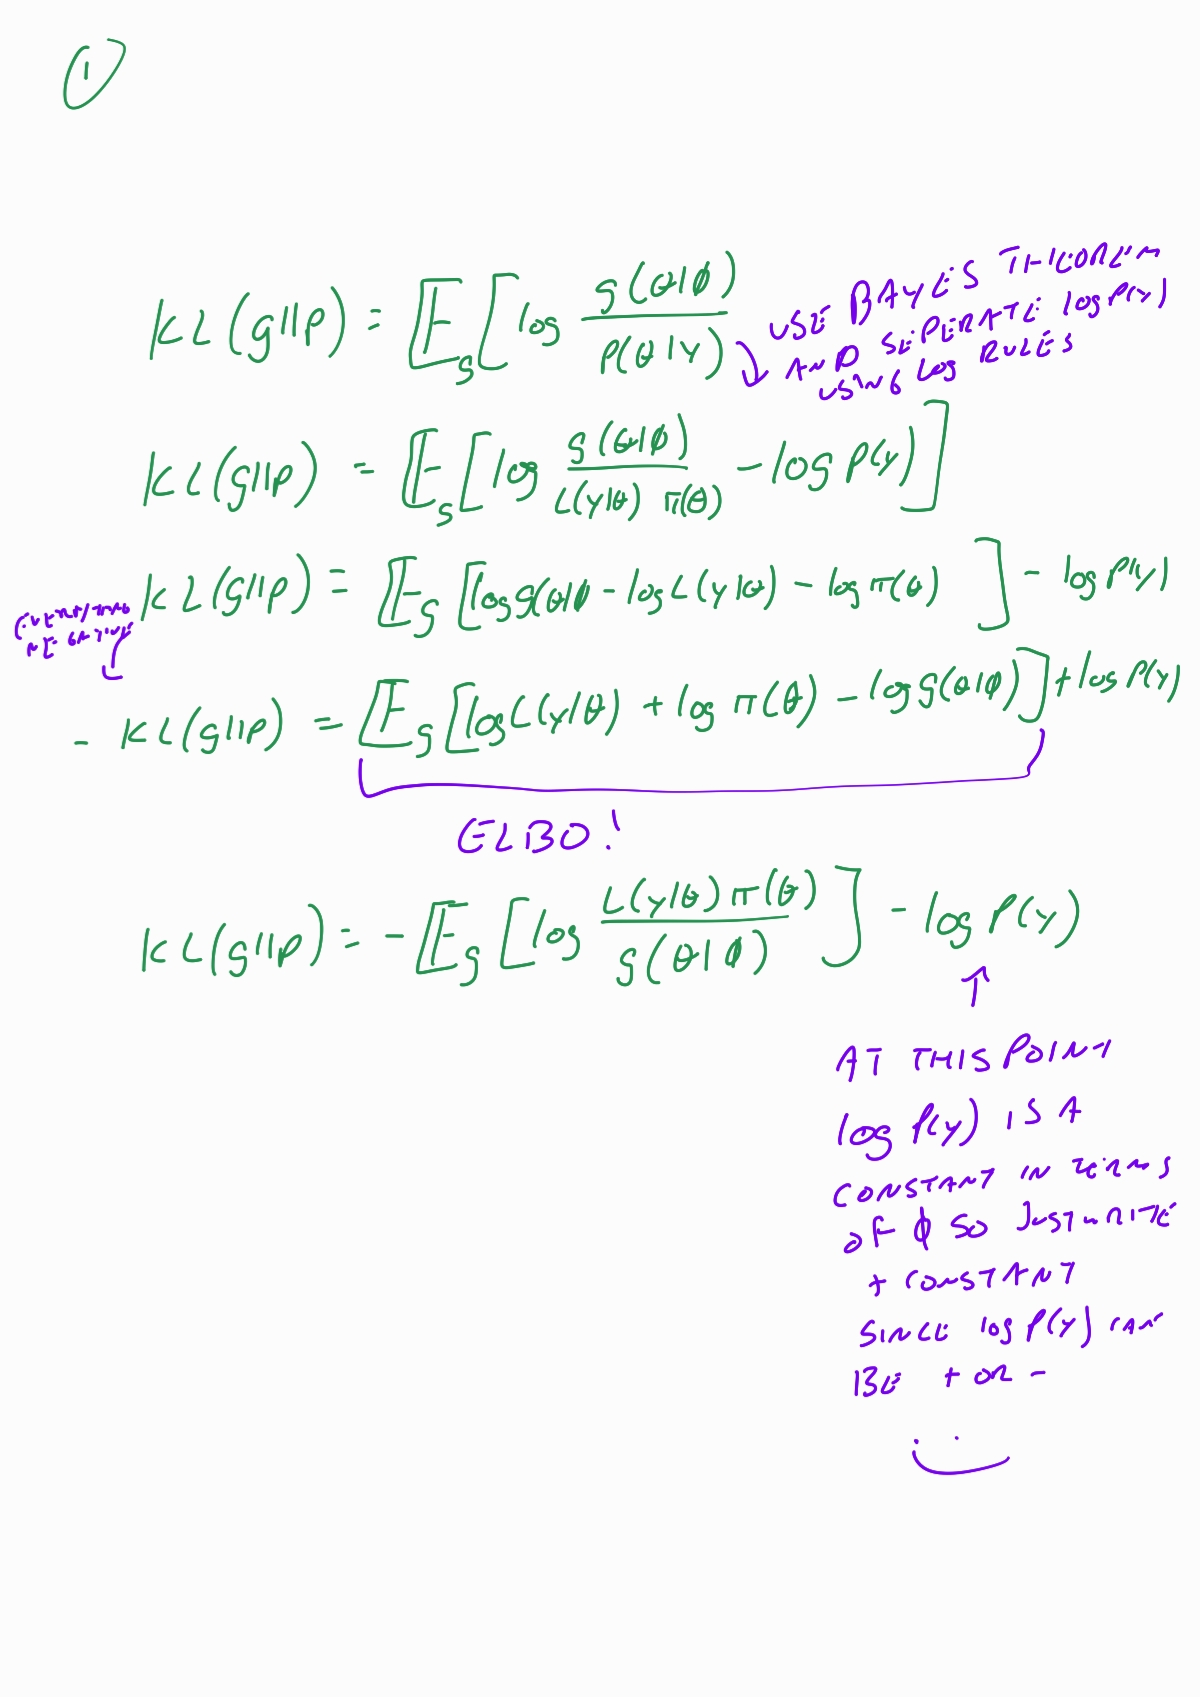

### Problem 2: Multinomial Regression

Bayes' theorem looks a little different with supervised learning. First, data is split up into predictors (i.e. $x$) and dependent variables (call them $y$). In this example, we will also call our parameters $\beta$, instead of $\theta$. 

So, Bayes' rule will look like this

$$
\pi(\beta \mid y, x) \propto L(y \mid \beta, x) \pi(\beta)
$$


1.

Prove the above using rules of conditioning and any other required assumptions. Attach a screenshot of your deriation to this notebook. 



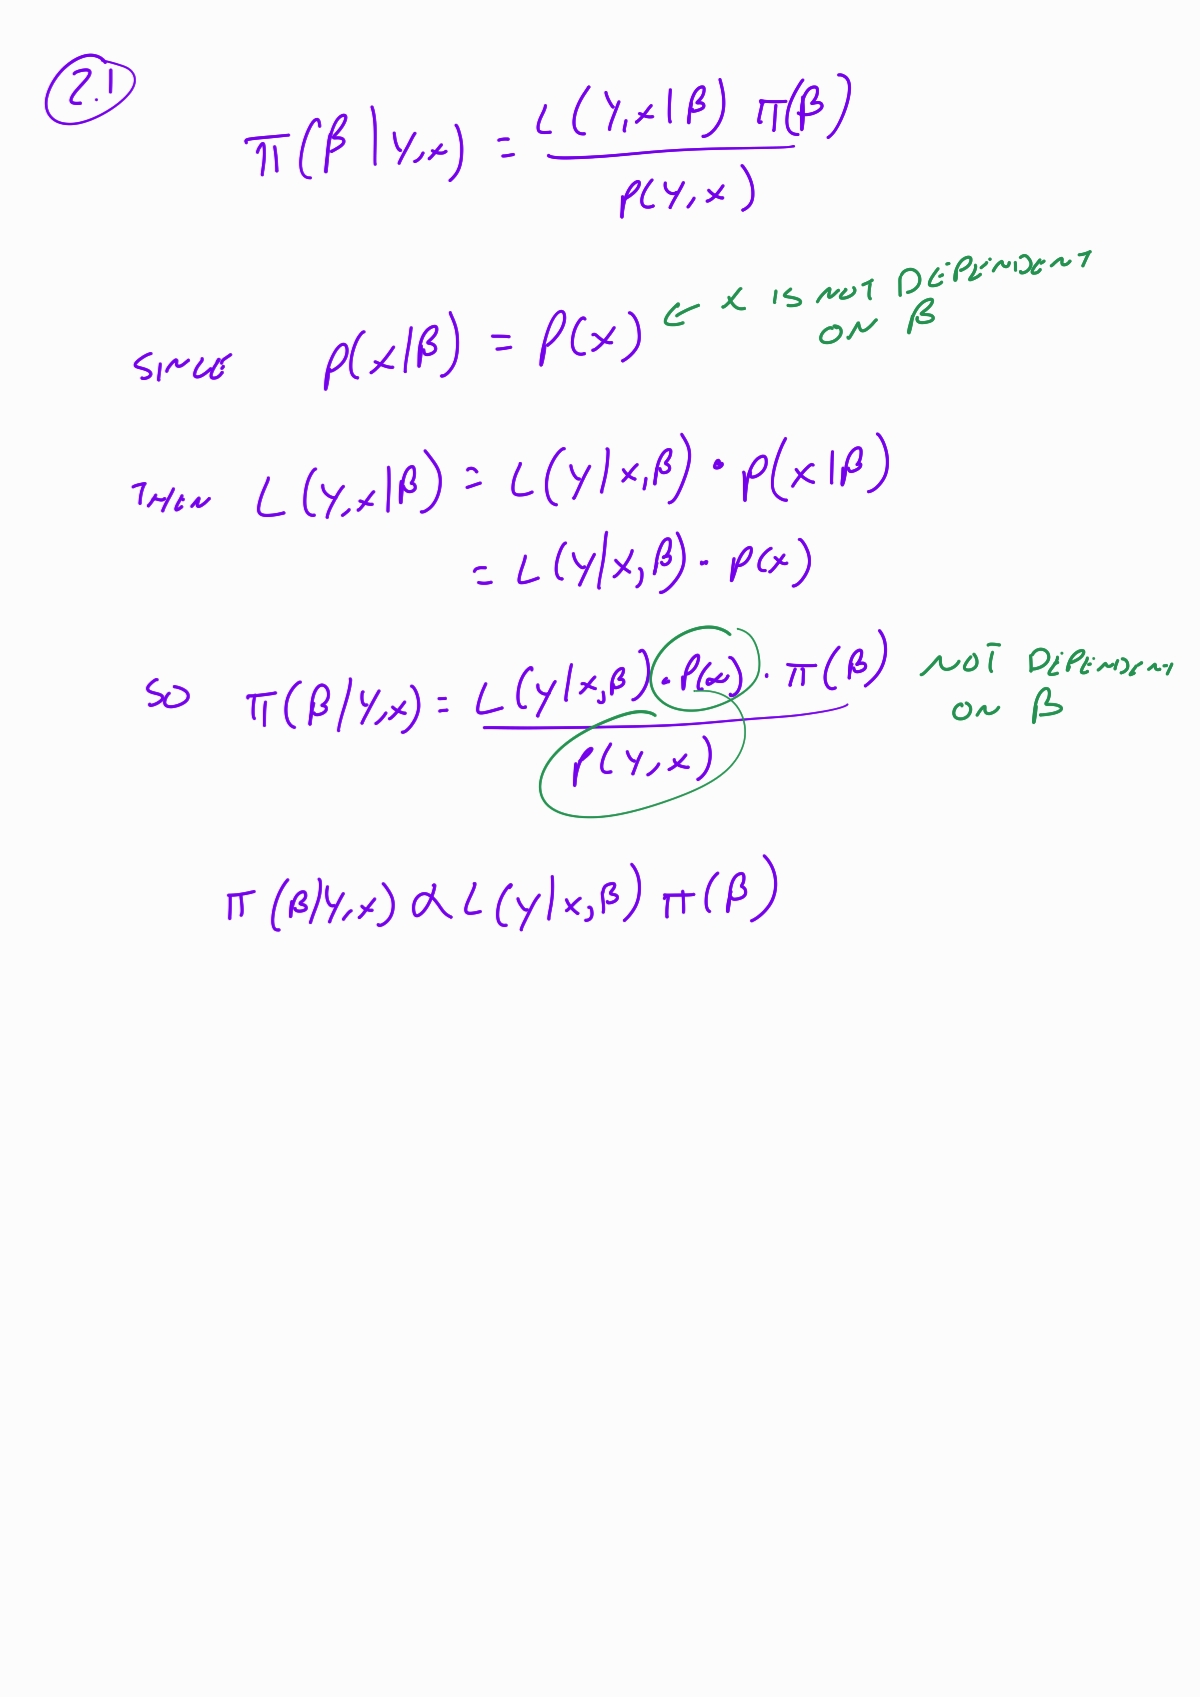

Previously, we modeled categorical output with a multinomial distribution. Our previous notation for one row of data was as follows:

Let $y = (y_1, y_2, \ldots, y_k)$ be a vector of counts.

We assume that there is a known total count (which means $\sum_i y_i = n$). 

A special case of the multinomial distribution--when $\sum_i y_i$ is $1$--is the **Categorical Distribution**. 

This was just like the distinction between Bernoulli and Binomial random variables. A Bernoulli is when there is one trial, and a Binomial is when there are many. Here it is the same. A Categorical random variable is when there is only one trial, and a multinomial is more general and allows for multiple trails. Each trial here, though, each categorical realization, can have multiple outcomes!

Because there is only one trial for each categorical realization, there are multiple ways to represent it ina program. 

One way is the **one-hot-encoding**. It matches the notation that we were using above. We could represent each realization as a length $k$ vector, and only allow one of the elements to be $1$ (or "hot").

A more memory-efficient way is to just store the index/number of the category that took place (e.g. $3$). That's what we are doing with our data set. This way, we only need one column to store the dependent data.

2.

Suppose each message on a social media platform can have four possible sentiments: "outrage", "joking", "intrigued" and "bored". Suppose you are looking at three tweets. The first is outrage, the second is bored, and the third is intrigued. 

Write out two ways that you could represent this data. Describe your category ordering and index labeling. Does your counting start from $1$ or $0$. Are your categories ordered alphabetically? Use the one-hot encoding as well as the simple category labels.  Attach a screenshot of your deriation to this notebook. 

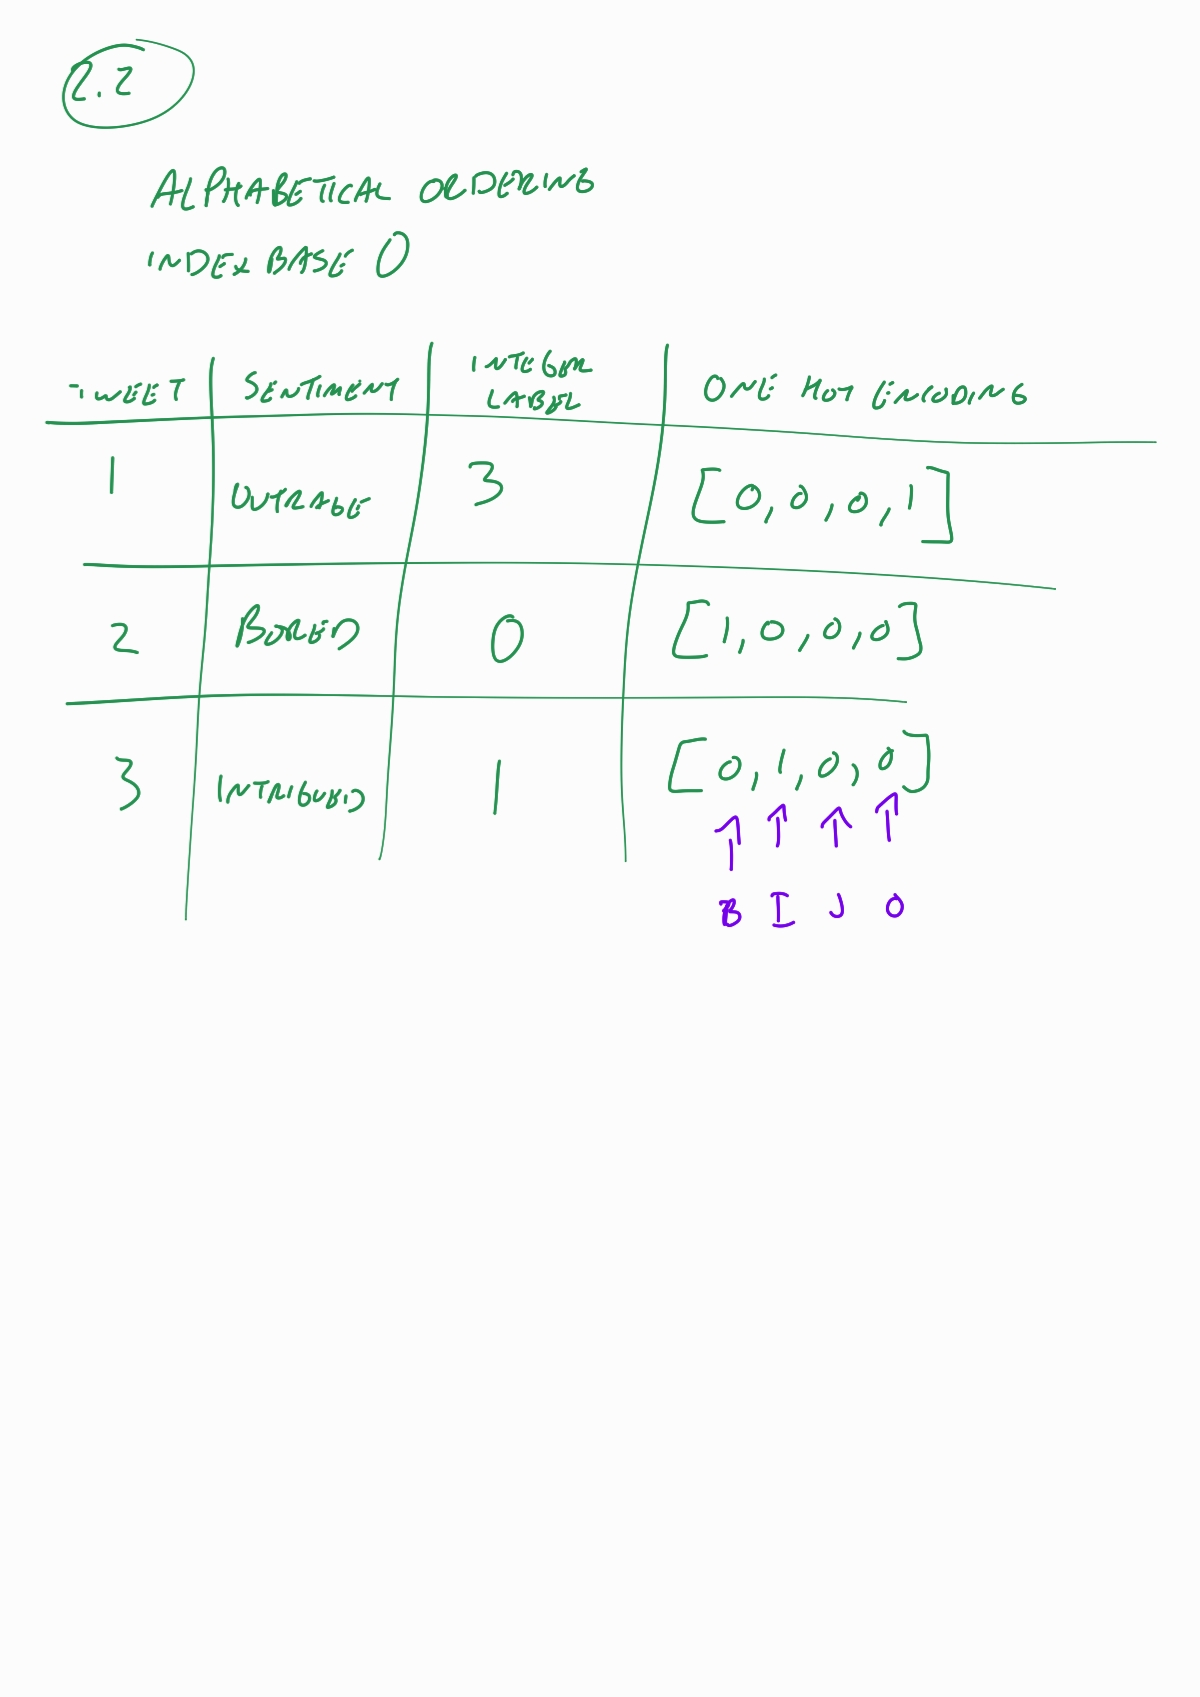

Previously, our data were so simplistic that we assumed each observation--each row of data (usually)--was from the same distribution. In other words, the probabilities of each "bucket" stay the same. We wrote it like this

Let $\theta = (\theta_1, \theta_2, \ldots, \theta_k)$ be the probabilities of any trial resulting in each of the $k$ outcomes. 

We also assume the only possible outcomes are these $k$ outcomes so $\sum_i \theta_i = 1$.

One way we can generalize this model is to allow the probabilities to vary. We could let them be affected by predictors. That's what we'll do in this homework. We will take our predictors, multiple them with some parameters, then use a nonlinear function to get the probabilities for each bucket. 

**Please note that we will describe the details of this model in more detail in a future module!**



Here is our high-level notation:

 - $N$: the number of observations/rows we have
 - $i$: the row number...goes from $1$ to $N$
 - $K$: number of categories/buckets we try to predict
 - $y_i$: the categorical dependent variable in row $i$ (it can be $1, \ldots, K$)
 - $y$ is the set of all $y_1, \ldots, y_N$
 - $D$: the number of predictors we can use to inform bucket probabilities
 - $x_i$: the row of predictor information. It has length $D$
 - $x$ is the matrix of all row predictors. It has shape $N \times D$

To drive this home, let's look at our specific data set, and try to make it look like this notation. 

In [3]:
d = pd.read_csv("SoftmaxRegData1.csv")
y = d['Y']
x = d[['X1','X2']].assign(intercept=1)
print(y.head())
print("\n\nunique y values: ", np.unique(y), "\n\n")
x.head()

0    2
1    1
2    3
3    3
4    3
Name: Y, dtype: int64


unique y values:  [1 2 3 4] 




,X1,X2,intercept
0,-0.087147,-1.081342,1
1,-0.722566,-1.583863,1
2,0.179190,0.971790,1
3,-1.159752,0.502624,1
4,-0.727118,1.375704,1


Our parameters of the model are "weights" that we weight predictors by. 

For parsimony, we use the same weights for each row of data. 

Also, each column of $\beta$ will take data an give a probability output *for each possible outcome.* 

This makes the weight matrix $\beta$ a $D \times K$. For us, that's $3 \times 4$.

We can write our likelihood in a few different ways.

$$
L(y \mid x, \beta) = \prod_{i=1}^N L(y_i \mid x_i, \beta)
$$
and
$$
L(y_i \mid x_i, \beta) = \text{Categorical}(\text{softmax}(x_i ^\intercal \beta) )
$$

**We will discuss the softmax function more later.** Suffice it to say that $\text{softmax}(x_i ^\intercal \beta)$ is a column vector of probabilities. Each probability describes the chances of each possible outome of the dependent variable $y_i$. Further, these probabilities depend on data for that particular row. They were kind of like our $\theta$s from before, but they now depend on the data we have in a particular row.

2.

I have provided a `.stan` file called `multinomial_regression.stan` that describes the model above. Take a look at it, and observe how it maps to the above description of the model. After you are comfortable with it, build your model into an object called `model`.


In [4]:
model_code = os.path.join('.', 'multinomial_regression.stan')
model = CmdStanModel(stan_file=model_code)

3. 

Use NUTS the MCMC algorithm to draw samples from this posterior. 

Do all the $\hat{R}$s look good for each parameter? What are your parameter estimates? What are 90% credible intervals for those parameter estimates? Don't worry about writing too much...just call `.summary()` in a cell.

Which parameters are very correlated (a posteriori) and how so? Why do you think is this the case? Justify your answer. Use `pd.plotting.scatter_matrix()` to visualize all the pairwise correlations of the posterior samples. 

In [5]:
our_data = {'K': d.iloc[:,-1].nunique(), 'N': d.shape[0], 'D': d.shape[1], 'y': y, 'x': x}
fit = model.sample(our_data)

17:44:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:44:55 - cmdstanpy - INFO - CmdStan done processing.


In [33]:
summary = fit.summary()
summary

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,-166.564000,0.067176,2.47048,-171.171000,-166.238000,-163.149000,1352.51,28.6330,1.001290
"beta[1,1]",-4.476920,0.067269,2.60813,-8.678510,-4.461460,0.001079,1503.25,31.8241,1.003300
"beta[1,2]",0.953306,0.066762,2.57993,-3.253140,0.936921,5.375720,1493.33,31.6141,1.002210
"beta[1,3]",-3.741600,0.068009,2.60866,-7.927890,-3.771010,0.640801,1471.32,31.1482,1.003470
"beta[1,4]",7.492430,0.067145,2.65345,3.156790,7.477050,11.917900,1561.71,33.0618,1.002420
"beta[2,1]",-2.606040,0.059298,2.45879,-6.737390,-2.585730,1.389360,1719.31,36.3983,0.999913
"beta[2,2]",-1.806590,0.058816,2.44719,-5.896400,-1.792370,2.131330,1731.16,36.6491,0.999961
"beta[2,3]",3.245320,0.058879,2.46122,-0.893095,3.258550,7.226810,1747.32,36.9914,0.999797
"beta[2,4]",0.870749,0.059457,2.44005,-3.198630,0.878500,4.806740,1684.21,35.6553,0.999909
"beta[3,1]",-1.206880,0.069530,2.50429,-5.360490,-1.202420,2.855870,1297.24,27.4630,1.002720


The $\hat{R}$s are all really close to 1 indicidating the MCMC worked and our data is useful. The estimates of all the betas are in the Mean column (thought I suppose you could use the 50% (median) column since they are so close). The 90% credible interval for each beta can be seen from the 5% and the 95% columns. For example, beta[1,1] has an estimate of -4.4769 and a credible interval of (-8,6785, 0.001). I could do this for all 12 betas, but it would just be me retyping the chart.

In [7]:
posterior_df = fit.draws_pd()
beta_samples = posterior_df.filter(like="beta")

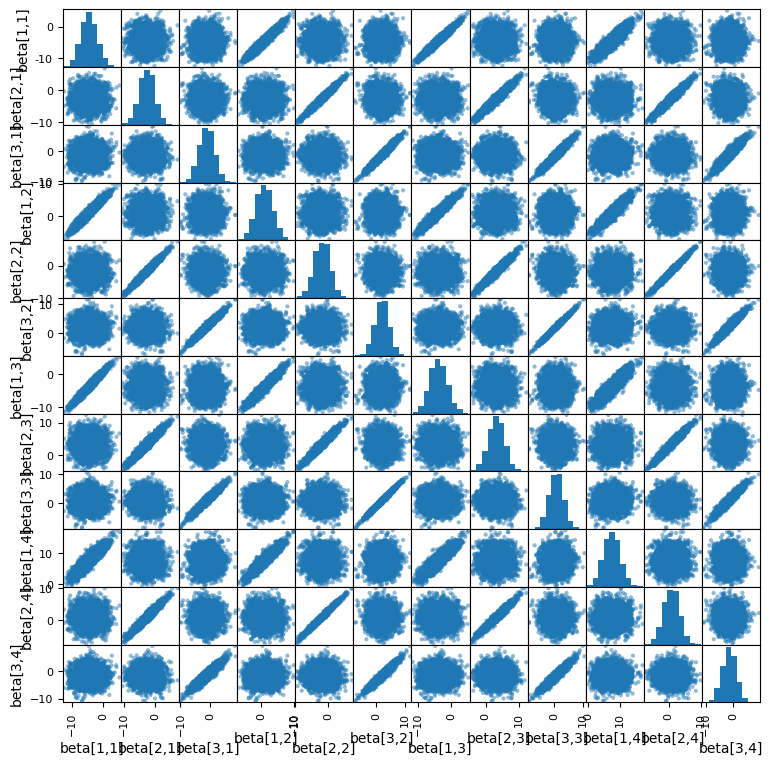

In [8]:
pd.plotting.scatter_matrix(beta_samples, figsize=(9,9))
plt.show()

In [30]:
corr = beta_samples.corr()
corr

,"beta[1,1]","beta[2,1]","beta[3,1]","beta[1,2]","beta[2,2]","beta[3,2]","beta[1,3]","beta[2,3]","beta[3,3]","beta[1,4]","beta[2,4]","beta[3,4]"
"beta[1,1]",1.000000,0.014495,0.028729,0.962234,0.011393,0.000747,0.977312,0.004030,0.003243,0.904354,0.006967,0.023009
"beta[2,1]",0.014495,1.000000,0.015326,0.010001,0.979837,-0.008070,0.001614,0.960918,-0.006597,-0.003541,0.966801,-0.002360
"beta[3,1]",0.028729,0.015326,1.000000,0.005691,-0.010179,0.972140,-0.001674,-0.003160,0.966012,0.029243,-0.006992,0.938759
"beta[1,2]",0.962234,0.010001,0.005691,1.000000,0.007283,0.010914,0.961676,0.013592,0.008033,0.937931,-0.002541,0.032029
"beta[2,2]",0.011393,0.979837,-0.010179,0.007283,1.000000,0.001314,0.018842,0.970808,0.002008,-0.005824,0.986396,0.005359
"beta[3,2]",0.000747,-0.008070,0.972140,0.010914,0.001314,1.000000,0.003494,0.005824,0.989053,0.035292,0.002571,0.963497
"beta[1,3]",0.977312,0.001614,-0.001674,0.961676,0.018842,0.003494,1.000000,-0.010208,0.020646,0.901912,0.013723,0.027452
"beta[2,3]",0.004030,0.960918,-0.003160,0.013592,0.970808,0.005824,-0.010208,1.000000,-0.010615,0.014547,0.974086,0.008406
"beta[3,3]",0.003243,-0.006597,0.966012,0.008033,0.002008,0.989053,0.020646,-0.010615,1.000000,0.030931,0.005819,0.956973
"beta[1,4]",0.904354,-0.003541,0.029243,0.937931,-0.005824,0.035292,0.901912,0.014547,0.030931,1.000000,0.016945,-0.028469


There are betas that seem correlated. Specifically betas with the first digits all seem stronlgy postively correlated. So beta[1,:] are correlated with all the other beta[1,:]. The same thing happens with 2 and 3. To confirm this I created a correlation matrix. It proves what I saw. What I think is happening is that there are 3 predictors so all the beta[1,:] are based off the first predictor, hence why they are very correlated.

4. 

Use Pathfinder VI algorithm to obtain a posterior approximation. 

Are the parameter estimates close to the MCMC parameter estimates? 

Was it much faster than the MCMC sampler?

Which parameters are very correlated (a posteriori) and how so? Why do you think is this the case? Use `pd.plotting.scatter_matrix()` to visualize all the pairwise correlations of the posterior samples. 

In [10]:
fit2 = model.pathfinder(our_data)

17:46:04 - cmdstanpy - INFO - Chain [1] start processing
17:46:05 - cmdstanpy - INFO - Chain [1] done processing


In [11]:
param_names2 = fit2.column_names
posterior2_df = pd.DataFrame(fit2.draws(), columns=param_names2)
beta2_samples = posterior2_df.filter(like="beta")

In [12]:
summary2 = posterior2_df.describe(percentiles=[0.05, 0.95]).T
summary2[['mean', '5%', '95%']]

,mean,5%,95%
lp_approx__,-6.707340,-10.671100,-1.850894
lp__,-194.135187,-197.451300,-192.296000
"beta[1,1]",-4.857753,-5.613090,-3.796670
"beta[2,1]",-2.350773,-2.728000,-1.593860
"beta[3,1]",-1.507949,-2.517560,-0.819849
"beta[1,2]",0.502201,-0.122948,1.394490
"beta[2,2]",-1.367489,-1.765180,-0.902470
"beta[3,2]",1.947140,1.126017,2.398520
"beta[1,3]",-4.153991,-5.003600,-3.152820
"beta[2,3]",3.594192,3.073470,4.047810


In [63]:
advi_diff = summary.iloc[1:,0] - summary2.iloc[2:,1]
advi_diff

beta[1,1]    0.380833
beta[1,2]    0.451105
beta[1,3]    0.412391
beta[1,4]    0.563276
beta[2,1]   -0.255267
beta[2,2]   -0.439101
beta[2,3]   -0.348872
beta[2,4]   -0.304107
beta[3,1]    0.301069
beta[3,2]    0.150440
beta[3,3]    0.385525
beta[3,4]    0.065323
dtype: float64

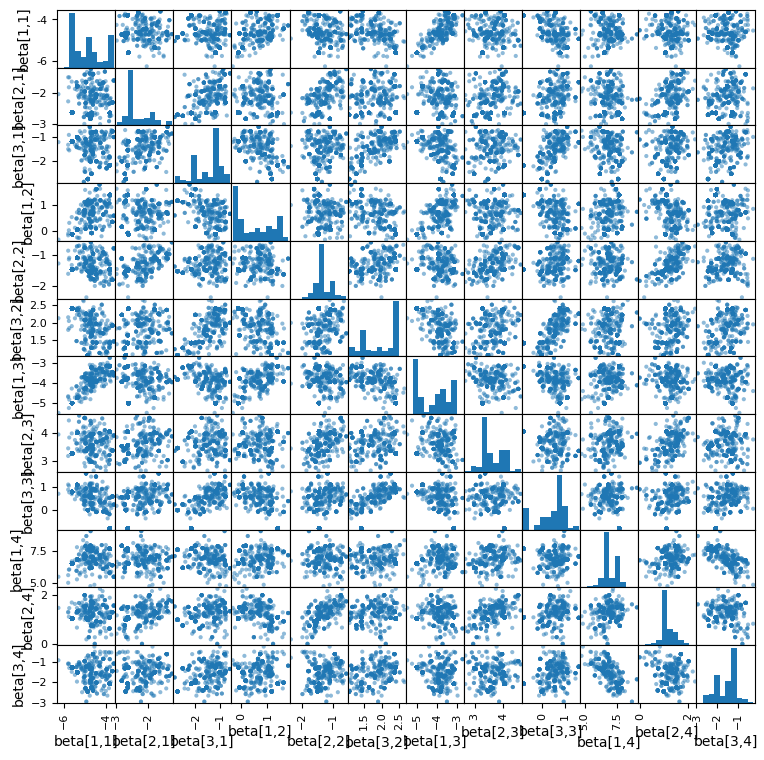

In [13]:
pd.plotting.scatter_matrix(beta2_samples, figsize=(9,9))
plt.show()

In [29]:
corr2 = beta2_samples.corr()
corr2

,"beta[1,1]","beta[2,1]","beta[3,1]","beta[1,2]","beta[2,2]","beta[3,2]","beta[1,3]","beta[2,3]","beta[3,3]","beta[1,4]","beta[2,4]","beta[3,4]"
"beta[1,1]",1.000000,0.068845,-0.479101,0.797735,-0.069389,-0.748559,0.934180,0.447571,-0.725292,0.432972,0.096772,-0.441569
"beta[2,1]",0.068845,1.000000,0.417073,0.082323,0.629774,0.090946,0.050953,0.353079,0.358531,-0.156533,0.492917,0.229786
"beta[3,1]",-0.479101,0.417073,1.000000,-0.692440,0.180813,0.806461,-0.614380,-0.181565,0.760243,-0.507929,0.207687,0.605902
"beta[1,2]",0.797735,0.082323,-0.692440,1.000000,-0.044164,-0.801149,0.844580,0.426561,-0.727950,0.498508,-0.124958,-0.420809
"beta[2,2]",-0.069389,0.629774,0.180813,-0.044164,1.000000,0.217800,-0.043134,0.482584,0.247304,-0.065684,0.675265,0.213012
"beta[3,2]",-0.748559,0.090946,0.806461,-0.801149,0.217800,1.000000,-0.808817,-0.240609,0.764363,-0.412578,0.087062,0.640741
"beta[1,3]",0.934180,0.050953,-0.614380,0.844580,-0.043134,-0.808817,1.000000,0.382874,-0.666734,0.481611,0.085973,-0.474763
"beta[2,3]",0.447571,0.353079,-0.181565,0.426561,0.482584,-0.240609,0.382874,1.000000,-0.389773,0.454959,0.505596,-0.264466
"beta[3,3]",-0.725292,0.358531,0.760243,-0.727950,0.247304,0.764363,-0.666734,-0.389773,1.000000,-0.481095,0.176374,0.559792
"beta[1,4]",0.432972,-0.156533,-0.507929,0.498508,-0.065684,-0.412578,0.481611,0.454959,-0.481095,1.000000,0.147826,-0.785188


The means of the betas are similar to the MCMC sampler. As you can see from the advi_diff the highest difference is 0.56 away indicating how close the estimates are.
The ADVI sampler ran much quicker than the MCMC sampler.
There are some parameters that seem a bit correlated. This time some of them are positive and some are negative. The only parameters that have a correlation greater than |0.5| have to deal with beta 3. I think this is because ADVI unconstrains the variables and then reconstrains them. In the process of uncontraining the the parameters lose the dependence. In the process of reconstraining them the further down the parameter list you go, the less independence they have in order to make the distribution work.

5. 

Use the ADVI algorithm to obtain a posterior approximation. 

Are the parameter estimates close to the pathfinder's estimates?

Was it much faster than the MCMC sampler?

Which parameters are very correlated (a posteriori) and how so? Why do you think is this the case? Use `pd.plotting.scatter_matrix()` to visualize all the pairwise correlations of the posterior samples. 

In [14]:
fit3 = model.variational(our_data)

17:46:29 - cmdstanpy - INFO - Chain [1] start processing
17:46:29 - cmdstanpy - INFO - Chain [1] done processing


In [15]:
param_names3 = fit3.column_names
posterior3_df = pd.DataFrame(fit3.variational_sample, columns=param_names3)
beta3_samples = posterior3_df.filter(like="beta")

In [16]:
summary3 = posterior3_df.describe(percentiles=[0.05, 0.95]).T
summary3[['mean', '5%', '95%']]

,mean,5%,95%
lp__,0.000000,0.000000,0.000000
log_p__,-197.679182,-206.070050,-192.530800
log_g__,-5.993148,-10.162240,-2.627691
"beta[1,1]",-5.010400,-5.383042,-4.616259
"beta[2,1]",-3.270074,-3.593769,-2.925357
"beta[3,1]",-1.353101,-1.704012,-1.021474
"beta[1,2]",0.376043,-0.066720,0.801316
"beta[2,2]",-2.428572,-2.747180,-2.099140
"beta[3,2]",1.908651,1.607625,2.217441
"beta[1,3]",-4.204845,-4.625439,-3.781440


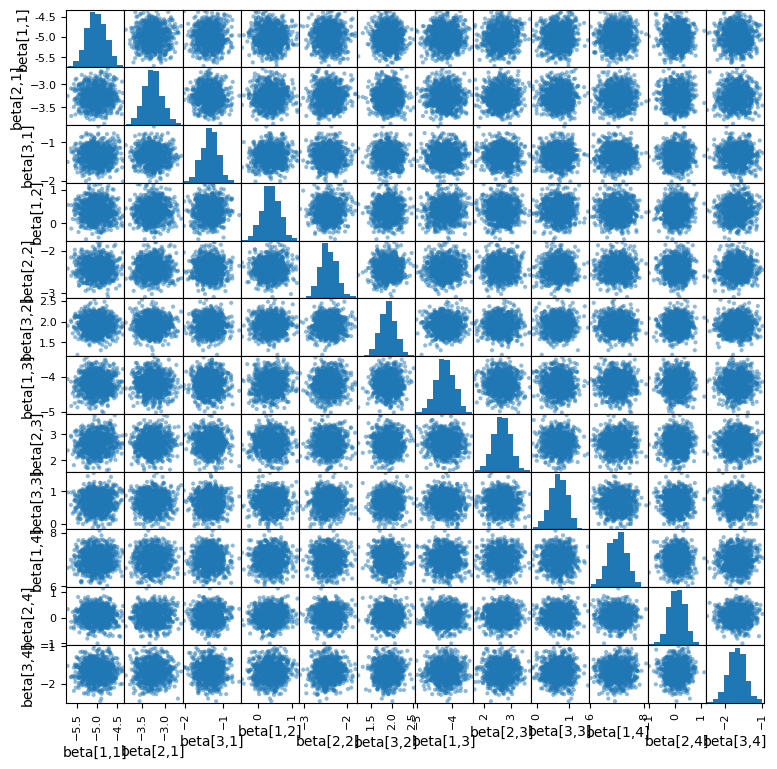

In [17]:
pd.plotting.scatter_matrix(beta3_samples, figsize=(9,9))
plt.show()

In [62]:
corr3 = beta3_samples.corr()
corr3

,"beta[1,1]","beta[2,1]","beta[3,1]","beta[1,2]","beta[2,2]","beta[3,2]","beta[1,3]","beta[2,3]","beta[3,3]","beta[1,4]","beta[2,4]","beta[3,4]"
"beta[1,1]",1.000000,-0.008198,0.011159,-0.031480,-0.027452,-0.013240,0.011433,0.098115,0.045723,0.041062,-0.009917,-0.038481
"beta[2,1]",-0.008198,1.000000,-0.075141,0.011912,0.030244,-0.017713,-0.032074,0.049443,0.005828,0.020974,0.011137,0.038523
"beta[3,1]",0.011159,-0.075141,1.000000,0.052383,-0.017237,-0.002751,0.009984,-0.018145,0.018093,-0.014823,0.019374,-0.012804
"beta[1,2]",-0.031480,0.011912,0.052383,1.000000,0.039005,0.035380,0.066453,-0.009569,0.017442,-0.001666,0.070072,0.036295
"beta[2,2]",-0.027452,0.030244,-0.017237,0.039005,1.000000,0.063527,0.022387,0.011915,0.060824,0.005237,0.018533,0.066285
"beta[3,2]",-0.013240,-0.017713,-0.002751,0.035380,0.063527,1.000000,0.006861,0.012092,0.015997,-0.053478,0.015689,0.022016
"beta[1,3]",0.011433,-0.032074,0.009984,0.066453,0.022387,0.006861,1.000000,-0.040494,-0.013539,-0.002506,-0.003912,0.019397
"beta[2,3]",0.098115,0.049443,-0.018145,-0.009569,0.011915,0.012092,-0.040494,1.000000,-0.020995,0.022347,0.009149,0.044827
"beta[3,3]",0.045723,0.005828,0.018093,0.017442,0.060824,0.015997,-0.013539,-0.020995,1.000000,-0.037079,-0.006177,0.016097
"beta[1,4]",0.041062,0.020974,-0.014823,-0.001666,0.005237,-0.053478,-0.002506,0.022347,-0.037079,1.000000,-0.007981,0.063506


In [65]:
path_diff = summary.iloc[1:,0] - summary3.iloc[3:,1]
path_diff

beta[1,1]    0.533480
beta[1,2]    0.577263
beta[1,3]    0.463245
beta[1,4]    0.488849
beta[2,1]    0.664034
beta[2,2]    0.621982
beta[2,3]    0.587791
beta[2,4]    0.793502
beta[3,1]    0.146221
beta[3,2]    0.188929
beta[3,3]    0.149691
beta[3,4]    0.158573
dtype: float64

The means of the betas are similar to the MCMC sampler. As you can see from the path_diff the highest difference is 0.79 away indicating how close the estimates are. The are a bit further away thant he ADVI were
The pathfinder sampler ran much quicker than the MCMC sampler.
There are no parameters that seem correlated here. All correlations we less than |0.1| indicating no correlation. I think the way pathfinder works assumes independence between parameters (or that is doesn't matter) so it makes sense there is little to no correlation.

6.

Describe two different approaches on how to simulate from the posterior predictive distribution. Why is this more interesting than simulating from the posterior preditive of our other models? 

Hint: did we make any modeling assumptions for the predictor data?

Two different approaches to simulate from the posterior predictive are two versions of Varaitional Inference known as ADVI (Automatic Differentiation Variational Inference) and Pathfinder. ADVI uncontrains the parameters and simulates a distribution. It then reparameterizes them and optimizes the ELBO to get this simulated distribution as close to the posterior distribution as possible. Pathfinder starts with a point estimate and then uses an optimization to form a distribution and simulates the posterior. It then optimizes the ELBO to get this simulated distribution as close to the posterior distribution as possible. These are different because they are approximating the posterior by changing the parameters in some way to make the problem "easier". This is why the processes have less correlation with other parameters, but the cost is a loss in accuracy.